In [1]:
import sys, os

root_dir = os.getcwd()                     # where your notebook is
scripts_dir = os.path.join(root_dir, "Scripts")

# Add Scripts folder to Python import path
sys.path.append(scripts_dir)

print("Scripts folder added to path:", scripts_dir)

Scripts folder added to path: /home/hossain/Satellite-Image-Segmentation/Scripts


In [5]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import os
import glob
from torch.utils.data.dataset import Dataset, ConcatDataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import imageio
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp

import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Import custom modules from Scripts folder
from unet import UNET
from att_unet import AttentionUNet
from dataloader import get_dataloaders

# Qualitative Study

In [3]:
def visualize_all_models(index, imgs, masks, model_dict, figname=None, num_classes=12):
    """
    index: sample index from the batch
    model_dict: {"UNet": model1, "ResNet101-UNet": model2, "Attention-UNet": model3}
    """

    img = imgs[index].cpu()
    true = masks[index].cpu()

    # Anchor trick for colormap consistency
    true_anchor = true.clone()
    for c in range(num_classes):
        true_anchor[0:1, c] = c

    # ---------------------------------------------------------
    # Create Figure (5 columns)
    # ---------------------------------------------------------
    plt.figure(figsize=(30, 6))

    # 1. Input Image
    plt.subplot(1, 5, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title("Input Image", fontsize=14)
    plt.axis("off")

    # 2. True Mask
    plt.subplot(1, 5, 2)
    plt.imshow(true_anchor, cmap="tab20")
    plt.title("True Mask", fontsize=14)
    plt.axis("off")

    # ---------------------------------------------------------
    # 3–5. Predictions with mIoU
    # ---------------------------------------------------------
    col = 3
    for model_name, model in model_dict.items():

        with torch.no_grad():
            output = model(imgs)[index].cpu()  # logits for this image

        pred = torch.argmax(output, dim=0)

        # ----------------------------
        # Compute mIoU for this model
        # ----------------------------
        iou_list = []
        for cls in range(num_classes):
            pred_c = (pred == cls)
            true_c = (true == cls)

            if true_c.sum().item() == 0:  
                continue

            intersection = (pred_c & true_c).sum().float()
            union = pred_c.sum().float() + true_c.sum().float() - intersection
            iou = (intersection + 1e-10) / (union + 1e-10)
            iou_list.append(iou.item())

        model_mIoU = np.mean(iou_list) if iou_list else 0.0

        # Anchor trick for prediction
        pred_anchor = pred.clone()
        for c in range(num_classes):
            pred_anchor[0:1, c] = c

        # Plot
        plt.subplot(1, 5, col)
        plt.imshow(pred_anchor, cmap="tab20")
        plt.title(f"{model_name} | mIoU = {model_mIoU:.3f}", fontsize=14)
        plt.axis("off")

        col += 1

    plt.tight_layout()
    if figname:
        plt.savefig(f"{figname}.png", dpi=600,bbox_inches='tight')
    plt.show()


In [ ]:
## ------------------------------------------------------------
# Load Models
# ------------------------------------------------------------

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {}

# ---------------------------- UNet ----------------------------
model_unet = UNET(in_channels=3, out_channels=12).to(DEVICE)
model_unet.load_state_dict(torch.load("saved_models/best_model_unet.pt", map_location=DEVICE))
model_unet.eval()
models["UNet"] = model_unet

# ---------------------------- ResNet101 UNet ----------------------------
model_resnet = smp.Unet(
    encoder_name='resnet101',
    encoder_weights=None,  
    classes=12,
    activation=None,
    encoder_depth=5,
    decoder_channels=[256,128,64,32,16]
).to(DEVICE)

model_resnet.load_state_dict(torch.load("saved_models/best_model_resnet.pt", map_location=DEVICE))
model_resnet.eval()
models["ResNet101-UNet"] = model_resnet

# ---------------------------- Attention UNet ----------------------------
model_att = AttentionUNet(in_channels=3, out_channels=12).to(DEVICE)
model_att.load_state_dict(torch.load("saved_models/best_model_att_unet.pt", map_location=DEVICE))
model_att.eval()
models["Attention-UNet"] = model_att


In [ ]:
# ------------------------------------------------------------
    # Load DataLoaders
# ------------------------------------------------------------
train_loader, val_loader, test_loader = get_dataloaders(
        path=os.path.join(root_dir, "data-urban"),
        batch_size=8
    )

In [65]:
def get_specific_batch(loader, batch_number):
    """
    Returns the imgs, masks for a specific batch index.
    batch_number starts from 0.
    """
    for i, (imgs, masks) in enumerate(loader):
        if i == batch_number:
            return imgs.to(DEVICE), masks.to(DEVICE)
    
    raise ValueError(f"Batch {batch_number} exceeds loader length {len(loader)}")


In [ ]:
batch_num = 21
imgs, masks = get_specific_batch(test_loader, batch_num)
imgs = imgs.to(DEVICE)
masks = masks.to(DEVICE)

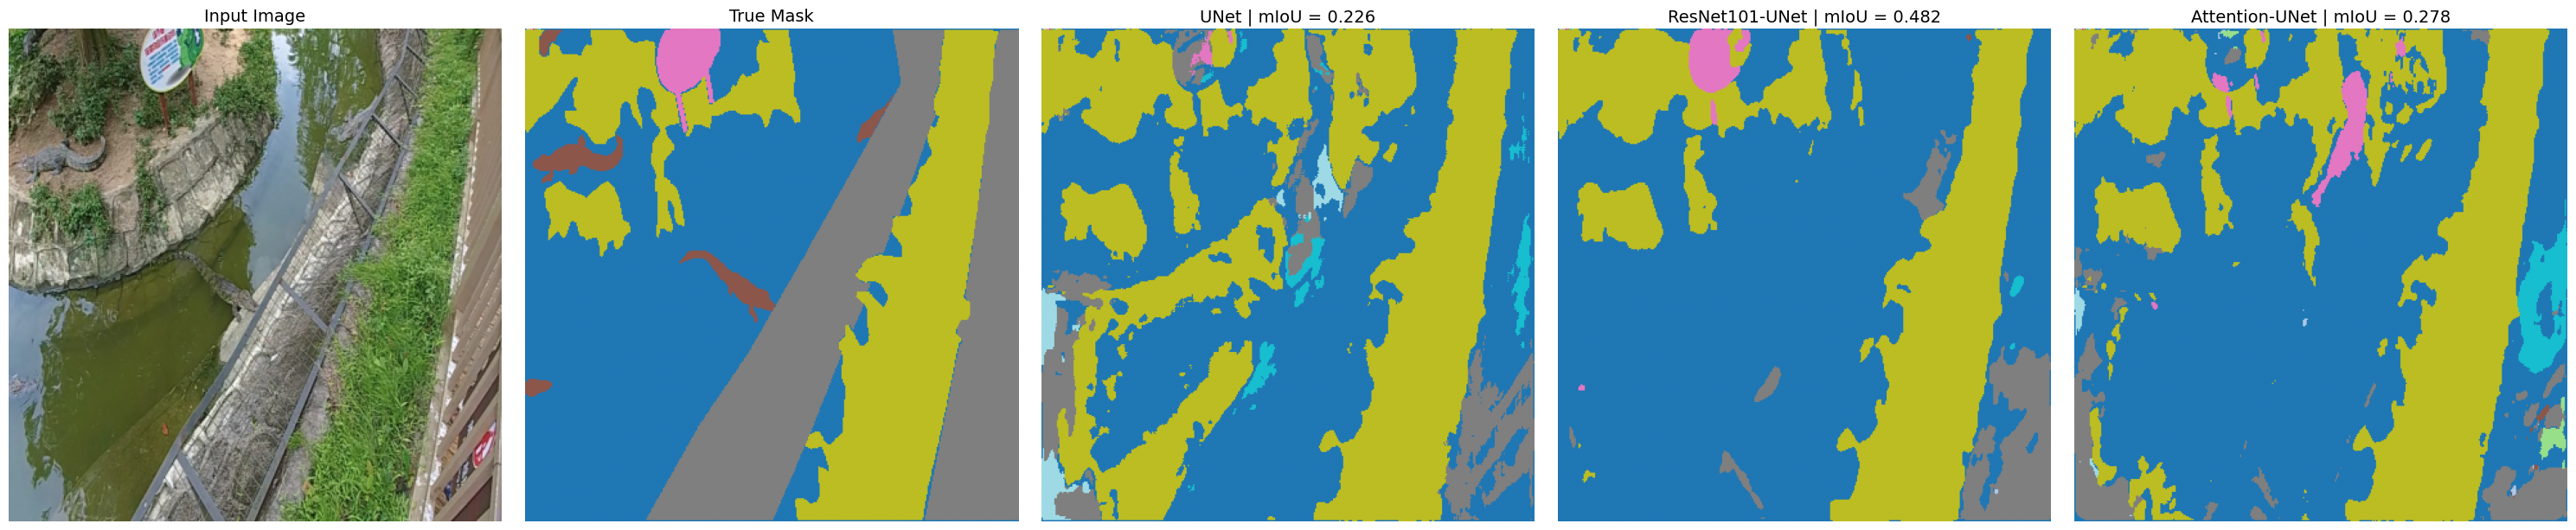

In [127]:
visualize_all_models(index=3, imgs=imgs, masks=masks, model_dict=models, figname="poor_sample2", num_classes=12)

In [ ]:
https://drive.google.com/file/d/1uv-qIYZQNm51o-uU4NcfFq9bmYRiwOXd/view?usp=sharing